<a href="https://colab.research.google.com/github/ludaladila/Mechanistic-Interpretability/blob/main/Mechanistic_Interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mechanistic Interpretability

**Name:** [Yiqing Liu]  
**Task:** XOR Classification  
**Model:** Tiny 2-2-1 MLP (2 inputs → 2 hidden neurons → 1 output)

---

## Introduction

In this assignment, I explore one of the simplest about **XOR (Exclusive OR)**.

**XOR**
First it's not linearly separable which means that single perceptron can't solve it. What's more, it is small enough to fully understand every weight and activation. So I think it is perfect for mechanistic interpretability.

**This project** will build the neural network to solve XOR, then understand exactly how it works from the inside.

---

##  The XOR Problem

XOR (Exclusive OR) returns 1 if inputs are different, 0 if they're the same:

| Input 1 | Input 2 | Output |
|---------|---------|--------|
| 0       | 0       | 0      |
| 0       | 1       | 1      |
| 1       | 0       | 1      |
| 1       | 1       | 0      |
---

In [221]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

np.random.seed(42)
torch.manual_seed(0)


# Part 1: Setup - Build and Train Our Tiny XOR Model

## 1.1 Create XOR Dataset

In [222]:
#The above code snippet was generated using Claude 4.5 Sonnet on 13/11/25 at 00:15 am.
# XOR Dataset: All 4 possible inputs
X = torch.tensor([[0, 0],
                  [0, 1],
                  [1, 0],
                  [1, 1]], dtype=torch.float32)

# XOR outputs
y = torch.tensor([[0],
                  [1],
                  [1],
                  [0]], dtype=torch.float32)

print("XOR Truth Table:")
print("-" * 30)
for i in range(4):
    print(f"Input: {X[i].numpy()} → Output: {int(y[i].item())}")
print("-" * 30)
print(f"Dataset shape: X={X.shape}, y={y.shape}")

XOR Truth Table:
------------------------------
Input: [0. 0.] → Output: 0
Input: [0. 1.] → Output: 1
Input: [1. 0.] → Output: 1
Input: [1. 1.] → Output: 0
------------------------------
Dataset shape: X=torch.Size([4, 2]), y=torch.Size([4, 1])


## 1.2 Build Our Tiny 2-2-1 MLP

**Architecture:**
- **Input Layer:** 2 neurons (x₁, x₂)
- **Hidden Layer:** 2 neurons with ReLU activation
- **Output Layer:** 1 neuron with Sigmoid activation (for binary classification)

In [223]:

class TinyXOR(nn.Module):
    """
    Tiny 2-2-1 MLP for XOR classification
    - 2 input features
    - 2 hidden neurons with ReLU
    - 1 output with Sigmoid
    """
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2)  # First layer: 2 inputs → 2 hidden neurons
        self.fc2 = nn.Linear(2, 1)  # Second layer: 2 hidden → 1 output

    def forward(self, x):
        # Hidden layer with ReLU activation
        h = torch.relu(self.fc1(x))
        # Output layer with Sigmoid for binary classification
        out = torch.sigmoid(self.fc2(h))
        return out, h  # Return both output and hidden activations for interpretability



## 1.3 Train the Model

We'll train using Binary Cross-Entropy loss and Adam optimizer. Since XOR only has 4 data points, we'll train for many epochs to ensure convergence.

In [224]:
def train_xor_model(max_attempts=5):
    """Train XOR model with automatic retry if it gets stuck in local minima"""

    for attempt in range(max_attempts):
        torch.manual_seed(attempt + 100)
        current_model = TinyXOR()

        # Training setup
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(current_model.parameters(), lr=0.01)

        # Training loop
        epochs = 3000
        losses = []
        accuracies = []

        for epoch in range(epochs):
            # Forward pass
            predictions, _ = current_model(X)
            loss = criterion(predictions, y)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track metrics
            losses.append(loss.item())
            predicted_classes = (predictions > 0.5).float()
            accuracy = (predicted_classes == y).float().mean().item()
            accuracies.append(accuracy)

            # Print progress every 2000 epochs
            if (epoch + 1) % 300 == 0:
                print(f"Epoch {epoch+1:5d} | Loss: {loss.item():.6f} | Accuracy: {accuracy*100:.1f}%")

        final_accuracy = accuracies[-1]
        final_loss = losses[-1]

        print(f"{'='*60}")
        print(f"Final Loss: {final_loss:.6f}")
        print(f"Final Accuracy: {final_accuracy*100:.1f}%")

        if final_accuracy >= 0.99:
            return current_model, losses, accuracies
    return current_model, losses, accuracies

model, losses, accuracies = train_xor_model()

print("\n Training phase complete")

Epoch   300 | Loss: 0.232683 | Accuracy: 100.0%
Epoch   600 | Loss: 0.047835 | Accuracy: 100.0%
Epoch   900 | Loss: 0.018637 | Accuracy: 100.0%
Epoch  1200 | Loss: 0.009789 | Accuracy: 100.0%
Epoch  1500 | Loss: 0.005987 | Accuracy: 100.0%
Epoch  1800 | Loss: 0.004000 | Accuracy: 100.0%
Epoch  2100 | Loss: 0.002825 | Accuracy: 100.0%
Epoch  2400 | Loss: 0.002077 | Accuracy: 100.0%
Epoch  2700 | Loss: 0.001570 | Accuracy: 100.0%
Epoch  3000 | Loss: 0.001216 | Accuracy: 100.0%
Final Loss: 0.001216
Final Accuracy: 100.0%

 Training phase complete


### 1.4 Visualize Training Progress

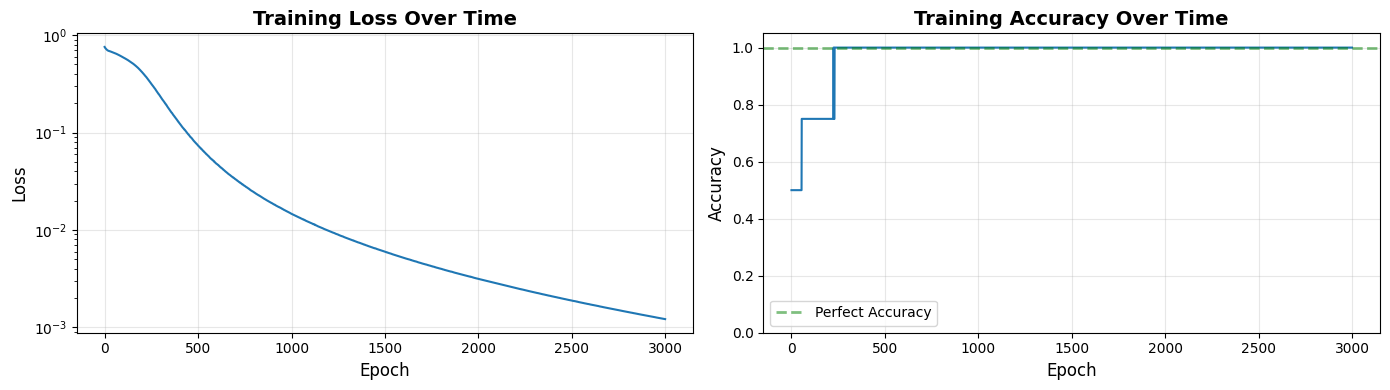

In [225]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Loss curve
ax1.plot(losses, linewidth=1.5)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss Over Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')  # Log scale to see convergence better

# Accuracy curve
ax2.plot(accuracies, linewidth=1.5)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training Accuracy Over Time', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1.05])
ax2.axhline(y=1.0, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Perfect Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()


### 1.5Predictions

In [226]:
model.eval()
with torch.no_grad():
    predictions, hidden_activations = model(X)
    predicted_classes = (predictions > 0.5).float()
print(f"{'Input':<15} {'True Label':<12} {'Prediction':<15} {'Predicted Class':<15} {'True/False':<5}")


for i in range(4):
    input_str = f"[{X[i][0]:.0f}, {X[i][1]:.0f}]"
    true_label = int(y[i].item())
    pred_prob = predictions[i].item()
    pred_class = int(predicted_classes[i].item())
    correct = "True" if pred_class == true_label else "False"

    print(f"{input_str:<15} {true_label:<12} {pred_prob:<15.4f} {pred_class:<15} {correct:<5}")


final_acc = (predicted_classes == y).float().mean().item()
print(f"Final Accuracy: {final_acc*100:.1f}%")


Input           True Label   Prediction      Predicted Class True/False
[0, 0]          0            0.0004          0               True 
[0, 1]          1            0.9993          1               True 
[1, 0]          1            0.9993          1               True 
[1, 1]          0            0.0030          0               True 
Final Accuracy: 100.0%


---

# Part 2: Explore - Diving Into the Model's Internals

## 2.1 Visualize the Decision Boundary

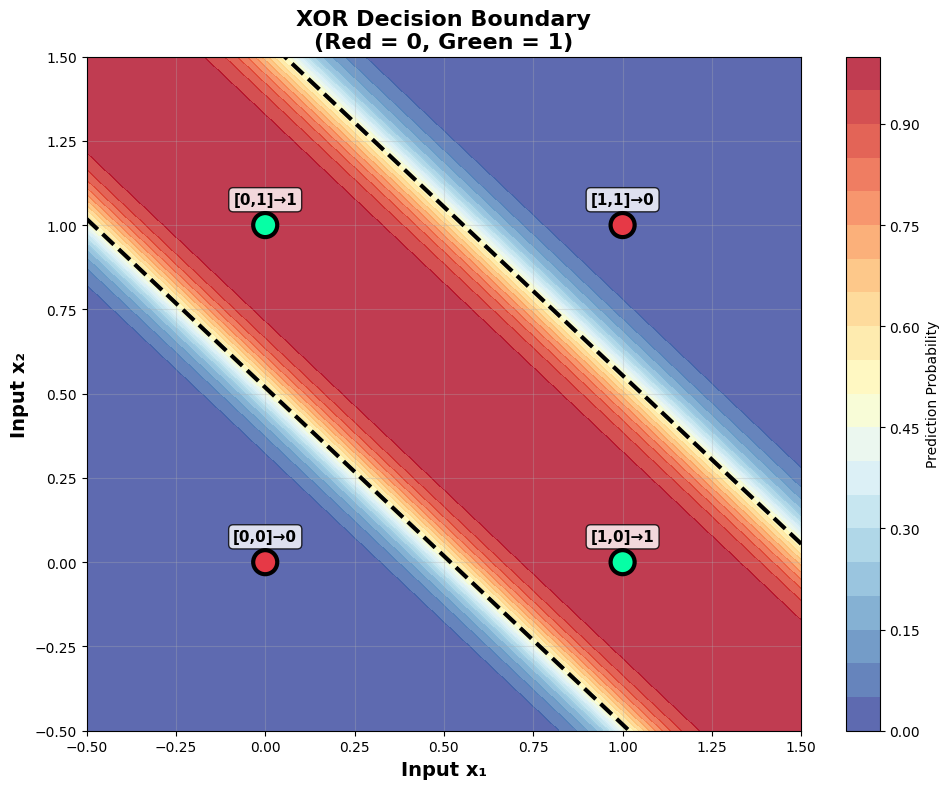

In [227]:
# Create a mesh grid to visualize decision boundary
x_min, x_max = -0.5, 1.5
y_min, y_max = -0.5, 1.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Flatten the grid and make predictions
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

model.eval()
with torch.no_grad():
    Z, _ = model(grid_points)
    Z = Z.numpy().reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(10, 8))
contour = plt.contourf(xx, yy, Z, levels=20, cmap='RdYlBu_r', alpha=0.8)
plt.colorbar(contour, label='Prediction Probability')

# Add decision boundary line at 0.5
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=3, linestyles='--')

# Plot training points
X_np = X.numpy()
y_np = y.numpy().flatten()
colors = ['#E63946' if label == 0 else '#06FFA5' for label in y_np]
plt.scatter(X_np[:, 0], X_np[:, 1], c=colors, s=300, edgecolors='black', linewidths=3, zorder=10)

# Add labels to points
for i, (x, y_val) in enumerate(X_np):
    label = int(y_np[i])
    plt.annotate(f'[{int(x)},{int(y_val)}]→{label}',
                 (x, y_val),
                 textcoords="offset points",
                 xytext=(0, 15),
                 ha='center',
                 fontsize=11,
                 fontweight='bold',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.xlabel('Input x₁', fontsize=14, fontweight='bold')
plt.ylabel('Input x₂', fontsize=14, fontweight='bold')
plt.title('XOR Decision Boundary\n(Red = 0, Green = 1)', fontsize=16, fontweight='bold')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Observation: The decision boundary is none-linear

## 2.2 Inspect Weight Matrices

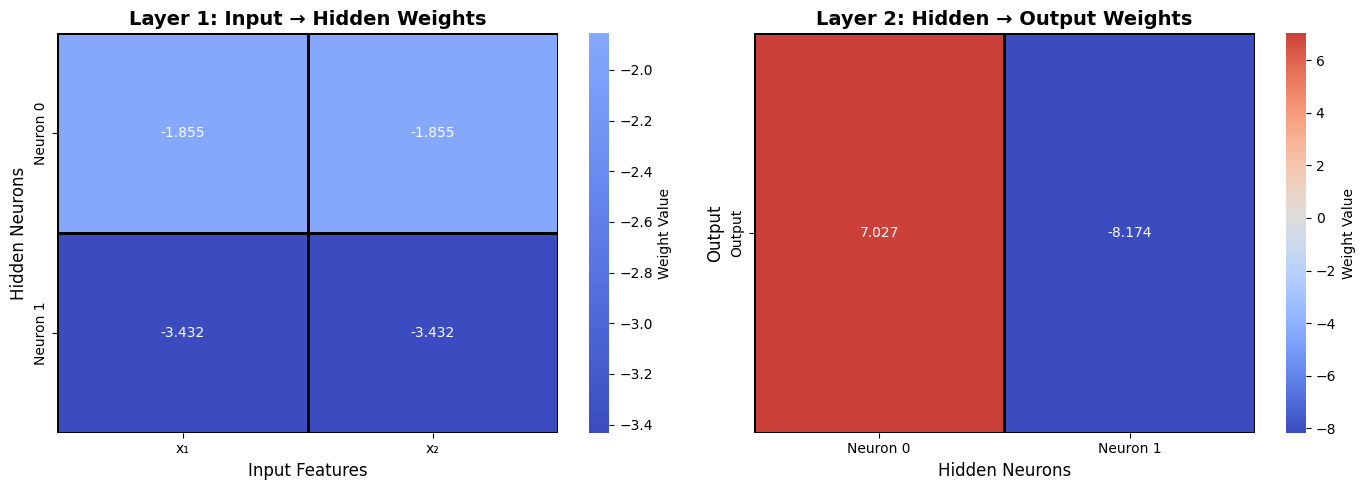

 Layer 1: Input → Hidden (2×2 matrix + 2 biases)
Weight Matrix W1:
[[-1.8554009 -1.8553634]
 [-3.432102  -3.4319417]]
Bias Vector b1: [3.7107534 3.4312787]
Interpretation:
Neuron 0: -1.855·x₁ + -1.855·x₂ + 3.711
Neuron 1: -3.432·x₁ + -3.432·x₂ + 3.431
 Layer 2: Hidden → Output (1×2 matrix + 1 bias)
Bias Vector b2: [-5.8127546]
Output = sigmoid(7.027·h₀ + -8.174·h₁ + -5.813)


In [228]:
# Extract weights and biases
W1 = model.fc1.weight.data.numpy()
b1 = model.fc1.bias.data.numpy()
W2 = model.fc2.weight.data.numpy()
b2 = model.fc2.bias.data.numpy()
# Visualize weights as heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Layer 1 weights
sns.heatmap(W1, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            xticklabels=['x₁', 'x₂'], yticklabels=['Neuron 0', 'Neuron 1'],
            cbar_kws={'label': 'Weight Value'}, ax=axes[0], linewidths=1, linecolor='black')
axes[0].set_title('Layer 1: Input → Hidden Weights', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Input Features', fontsize=12)
axes[0].set_ylabel('Hidden Neurons', fontsize=12)

# Layer 2 weights
sns.heatmap(W2, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            xticklabels=['Neuron 0', 'Neuron 1'], yticklabels=['Output'],
            cbar_kws={'label': 'Weight Value'}, ax=axes[1], linewidths=1, linecolor='black')
axes[1].set_title('Layer 2: Hidden → Output Weights', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hidden Neurons', fontsize=12)
axes[1].set_ylabel('Output', fontsize=12)

plt.tight_layout()
plt.show()

print(" Layer 1: Input → Hidden (2×2 matrix + 2 biases)")
print("Weight Matrix W1:")
print(W1)
print(f"Bias Vector b1: {b1}")
print("Interpretation:")
print(f"Neuron 0: {W1[0][0]:.3f}·x₁ + {W1[0][1]:.3f}·x₂ + {b1[0]:.3f}")
print(f"Neuron 1: {W1[1][0]:.3f}·x₁ + {W1[1][1]:.3f}·x₂ + {b1[1]:.3f}")

print(" Layer 2: Hidden → Output (1×2 matrix + 1 bias)")

print(f"Bias Vector b2: {b2}")
print(f"Output = sigmoid({W2[0][0]:.3f}·h₀ + {W2[0][1]:.3f}·h₁ + {b2[0]:.3f})")


## 2.3 Analyze Hidden Layer Activations

Input Sweeps: How Hidden Neurons Respond

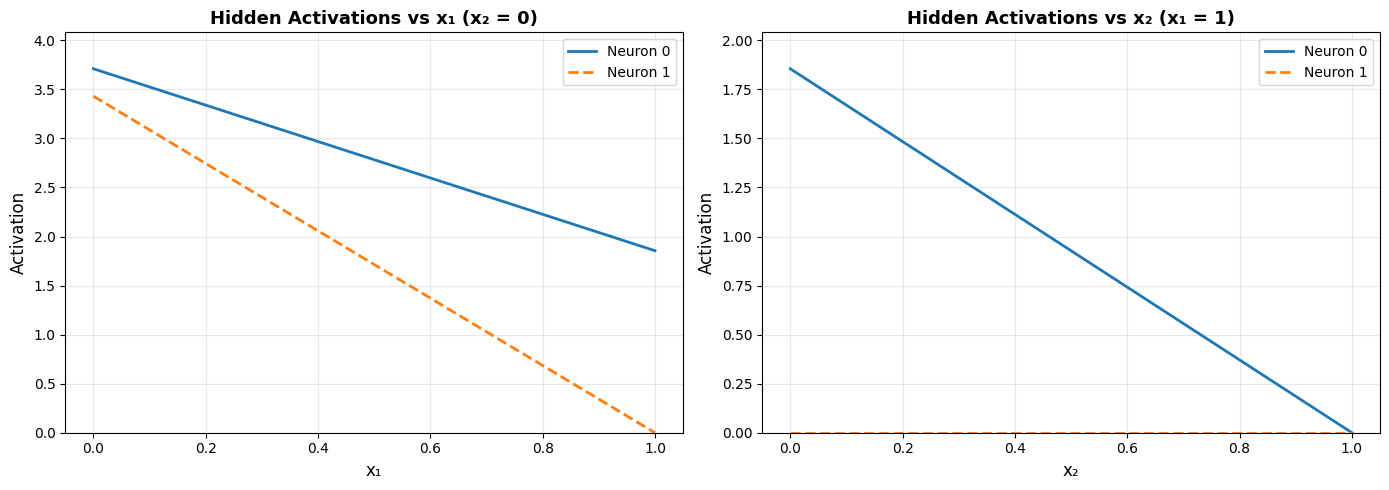

In [229]:
model.eval()
with torch.no_grad():
    # Fix x2 = 0, scan x1 from 0 → 1
    x1_vals = torch.linspace(0, 1, steps=50)
    inputs_x1 = torch.stack([x1_vals, torch.zeros_like(x1_vals)], dim=1)
    _, h_x1 = model(inputs_x1)   # (50, 2)
    h_x1_np = h_x1.cpu().numpy()

    # Fix x1 = 1, scan x2 from 0 → 1
    x2_vals = torch.linspace(0, 1, steps=50)
    inputs_x2 = torch.stack([torch.ones_like(x2_vals), x2_vals], dim=1)
    _, h_x2 = model(inputs_x2)
    h_x2_np = h_x2.cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# A helper function: automatically set y-axis upper bound (ReLU output ≥ 0)
def set_relu_ylim(ax, arr):
    ymin = 0.0
    ymax = arr.max()
    margin = 0.1 * (ymax - ymin + 1e-6)
    ax.set_ylim(ymin, ymax + margin)

# Left plot: Response of hidden layer as x1 goes from 0→1 (with x2=0)
axes[0].plot(x1_vals.cpu().numpy(), h_x1_np[:, 0], label='Neuron 0', linewidth=2)
axes[0].plot(x1_vals.cpu().numpy(), h_x1_np[:, 1], label='Neuron 1', linewidth=2, linestyle='--')
axes[0].set_title('Hidden Activations vs x₁ (x₂ = 0)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('x₁', fontsize=12)
axes[0].set_ylabel('Activation', fontsize=12)
set_relu_ylim(axes[0], h_x1_np)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Right plot: Response of hidden layer as x2 goes from 0→1 (with x1=1)
axes[1].plot(x2_vals.cpu().numpy(), h_x2_np[:, 0], label='Neuron 0', linewidth=2)
axes[1].plot(x2_vals.cpu().numpy(), h_x2_np[:, 1], label='Neuron 1', linewidth=2, linestyle='--')
axes[1].set_title('Hidden Activations vs x₂ (x₁ = 1)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('x₂', fontsize=12)
axes[1].set_ylabel('Activation', fontsize=12)
set_relu_ylim(axes[1], h_x2_np)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

1. When we sweep x1 from 0 to 1, both neurons start with high activationsand decrease steadily as x1 increases.
2. Neuron 1 eventually goes all the way to 0 when x1 = 1, but neuron 0 still stays positive about 1.86.
3. When we sweep x2 from 0 to 1 , neuron 0 gradually decreases to 0, while neuron 1 stays exactly 0 the whole time, showing it does not respond to x2 at all.

## 2.4 Visualize Ablation Impact


NEURON ABLATION RESULTS
Input        True XOR   Baseline     Neuron 0=0     Neuron 1=0    
[0,0]        0          0.0004       0.0000         1.0000        
[0,1]        1          0.9993       0.0030         0.9993        
[1,0]        1          0.9993       0.0030         0.9993        
[1,1]        0          0.0030       0.0030         0.0030        
Average Prediction Change:
Neuron 0 ablation: 0.4982
Neuron 1 ablation: 0.2499


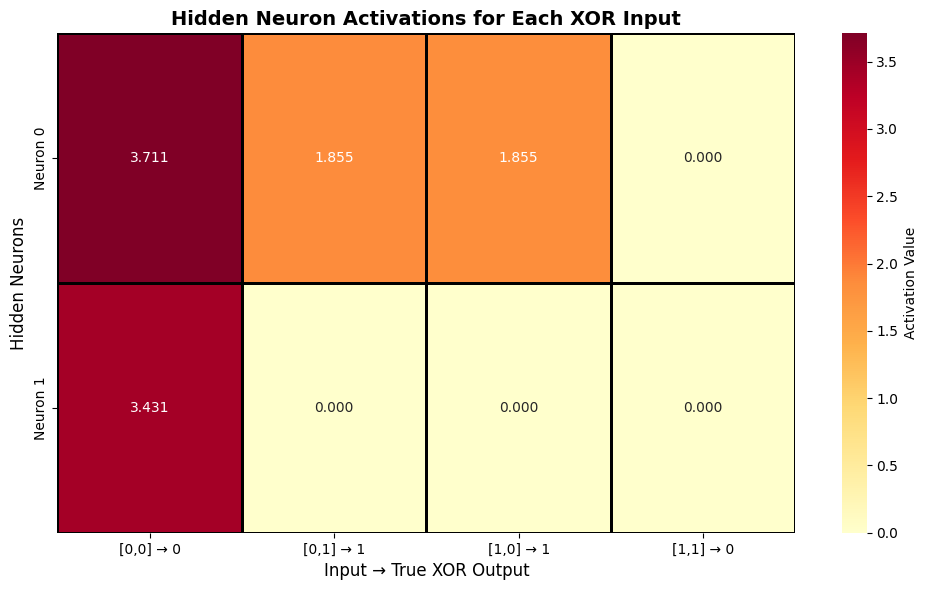

In [231]:
# Baseline predictions (no ablation)
model.eval()
with torch.no_grad():
    baseline_preds, baseline_h = model(X)
    baseline_preds = baseline_preds.numpy().flatten()

# Ablation: Test each neuron
ablation_results = {}

for neuron_idx in range(2):
    ablated_preds = []

    for i in range(4):
        x_single = X[i:i+1]

        with torch.no_grad():
            # Forward pass
            h = torch.relu(model.fc1(x_single))

            # Zero out the neuron
            h[:, neuron_idx] = 0

            # Continue forward pass
            out = torch.sigmoid(model.fc2(h))
            ablated_preds.append(out.item())

    ablation_results[neuron_idx] = np.array(ablated_preds)

# Display results
print("NEURON ABLATION RESULTS")
print(f"{'Input':<12} {'True XOR':<10} {'Baseline':<12} {'Neuron 0=0':<14} {'Neuron 1=0':<14}")

for i in range(4):
    input_str = f"[{int(X[i][0])},{int(X[i][1])}]"
    true_xor = int(y[i].item())
    baseline = baseline_preds[i]
    abl_0 = ablation_results[0][i]
    abl_1 = ablation_results[1][i]

    print(f"{input_str:<12} {true_xor:<10} {baseline:<12.4f} {abl_0:<14.4f} {abl_1:<14.4f}")


# Calculate impact metrics
impact_neuron0 = np.abs(ablation_results[0] - baseline_preds).mean()
impact_neuron1 = np.abs(ablation_results[1] - baseline_preds).mean()

print(f"Average Prediction Change:")
print(f"Neuron 0 ablation: {impact_neuron0:.4f}")
print(f"Neuron 1 ablation: {impact_neuron1:.4f}")
# Visualize activations as heatmap
fig, ax = plt.subplots(figsize=(10, 6))

# Create input labels
input_labels = [f"[{int(X[i][0])},{int(X[i][1])}] → {int(y[i].item())}" for i in range(4)]

sns.heatmap(h_np.T, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=input_labels, yticklabels=['Neuron 0', 'Neuron 1'],
            cbar_kws={'label': 'Activation Value'}, linewidths=2, linecolor='black')
ax.set_title('Hidden Neuron Activations for Each XOR Input', fontsize=14, fontweight='bold')
ax.set_xlabel('Input → True XOR Output', fontsize=12)
ax.set_ylabel('Hidden Neurons', fontsize=12)

plt.tight_layout()
plt.show()

Through the experiment, we can find that the neuron0 with larger impact is more functionally important

# Part 3: Explain

After investigation, here's the mechanistic story what I foound:

###3.1 The model solves XOR by learning two complementary linear detectors in the hidden layer that, when combined, create a non-linear decision boundary.


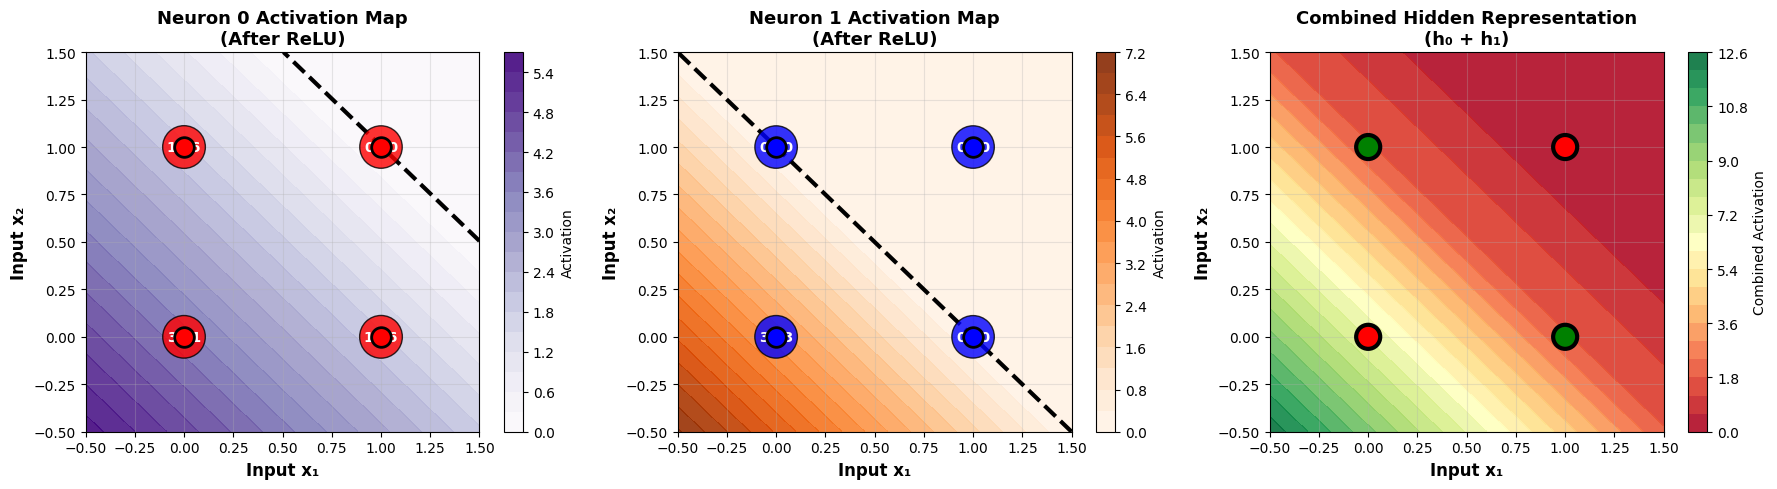

In [232]:

model.eval()
with torch.no_grad():
    _, h = model(X)
h_np = h.detach().cpu().numpy()


# Create mesh grid
x_min, x_max = -0.5, 1.5
y_min, y_max = -0.5, 1.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

# Get hidden activations for all grid points
model.eval()
with torch.no_grad():
    _, hidden_grid = model(grid_points)
    h0_grid = hidden_grid[:, 0].cpu().numpy().reshape(xx.shape)
    h1_grid = hidden_grid[:, 1].cpu().numpy().reshape(xx.shape)

# Plot individual neuron activations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ---------- Neuron 0 activation map ----------
im0 = axes[0].contourf(xx, yy, h0_grid, levels=20, cmap='Purples', alpha=0.9)
axes[0].contour(xx, yy, h0_grid, levels=[0], colors='black',
                linewidths=3, linestyles='--')

axes[0].scatter(X.numpy()[:, 0], X.numpy()[:, 1],
                c='red', s=200, edgecolors='black', linewidths=2, zorder=10)

for i, (x, y_val) in enumerate(X.numpy()):
    axes[0].annotate(f'{h_np[i][0]:.2f}', (x, y_val),
                     ha='center', va='center',
                     fontsize=10, fontweight='bold', color='white',
                     bbox=dict(boxstyle='circle', facecolor='red', alpha=0.8))

axes[0].set_xlabel('Input x₁', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Input x₂', fontsize=12, fontweight='bold')
axes[0].set_title('Neuron 0 Activation Map\n(After ReLU)',
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(im0, ax=axes[0], label='Activation')

# ---------- Neuron 1 activation map ----------
im1 = axes[1].contourf(xx, yy, h1_grid, levels=20, cmap='Oranges', alpha=0.9)
axes[1].contour(xx, yy, h1_grid, levels=[0], colors='black',
                linewidths=3, linestyles='--')

axes[1].scatter(X.numpy()[:, 0], X.numpy()[:, 1],
                c='blue', s=200, edgecolors='black', linewidths=2, zorder=10)

for i, (x, y_val) in enumerate(X.numpy()):
    axes[1].annotate(f'{h_np[i][1]:.2f}', (x, y_val),
                     ha='center', va='center',
                     fontsize=10, fontweight='bold', color='white',
                     bbox=dict(boxstyle='circle', facecolor='blue', alpha=0.8))

axes[1].set_xlabel('Input x₁', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Input x₂', fontsize=12, fontweight='bold')
axes[1].set_title('Neuron 1 Activation Map\n(After ReLU)',
                  fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(im1, ax=axes[1], label='Activation')

# ---------- Combined view: Both neurons ----------
combined = h0_grid + h1_grid
im2 = axes[2].contourf(xx, yy, combined, levels=20, cmap='RdYlGn', alpha=0.9)

axes[2].scatter(X.numpy()[:, 0], X.numpy()[:, 1],
                c=['red' if y[i].item() == 0 else 'green' for i in range(4)],
                s=300, edgecolors='black', linewidths=3, zorder=10)

for i, (x, y_val) in enumerate(X.numpy()):
    label = int(y[i].item())
    axes[2].annotate(f'{label}', (x, y_val),
                     ha='center', va='center',
                     fontsize=14, fontweight='bold', color='white')

axes[2].set_xlabel('Input x₁', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Input x₂', fontsize=12, fontweight='bold')
axes[2].set_title('Combined Hidden Representation\n(h₀ + h₁)',
                  fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)
plt.colorbar(im2, ax=axes[2], label='Combined Activation')

plt.tight_layout()
plt.show()



### 3.2.What does Each Neuron work

In [233]:
# Compute hidden activations for all 4 inputs
model.eval()
with torch.no_grad():
    predictions, h_activations = model(X)

h_np = h_activations.numpy()

print("HIDDEN LAYER ACTIVATIONS")
print(f"{'Input':<15} {'True XOR':<10} {'Neuron 0':<15} {'Neuron 1':<15} {'Prediction':<12}")
print("-"*80)

for i in range(4):
    input_str = f"[{int(X[i][0])}, {int(X[i][1])}]"
    true_xor = int(y[i].item())
    h0 = h_np[i][0]
    h1 = h_np[i][1]
    pred = predictions[i].item()
    print(f"{input_str:<15} {true_xor:<10} {h0:<15.4f} {h1:<15.4f} {pred:<12.4f}")

HIDDEN LAYER ACTIVATIONS
Input           True XOR   Neuron 0        Neuron 1        Prediction  
--------------------------------------------------------------------------------
[0, 0]          0          3.7108          3.4313          0.0004      
[0, 1]          1          1.8554          0.0000          0.9993      
[1, 0]          1          1.8554          0.0000          0.9993      
[1, 1]          0          0.0000          0.0000          0.0030      


Neuron 0 activates on all inputs other than (1,1), thus detecting at least one input is 0.

Neuron 1 activates only at (0,0), confirming the feature that both inputs are 0.

Therefore, we can see that these two hidden neurons together provide two complementary modes, enabling the output layer to correctly distinguish the case where XOR=1. That is, XOR=1 only when Neuron 0 is activated and Neuron 1 is not activated.


In details:

**The neuron 0** acts like a logical NAND gate, it fires on (0,0), (0,1), and (1,0), but turns off for (1,1).

**The neuron 1** acts like a logical NOR gate, it only fires when both inputs are 0.


### 3.3 The Final Combination: XOR = (NAND) AND (NOT NOR)

The output layer learns to combine these two features:

```
Output = (Neuron 0 is ON) AND (Neuron 1 is OFF)
```

### 3.4 Example
Take the input (1, 0) as an example:
The model first looks at the input and sends it into two hidden neurons.
Neuron 0 (NAND) turns on because the input is not (1,1). Neuron 1 (NOR) turns off because the input is not (0,0).

Then the output layer combines them:
It sees “Neuron 0 = on” and “Neuron 1 = off”, so the model correctly outputs XOR = 1.

### 3.5 the model's verification


In [234]:
# Verify the example (1,0)
model.eval()
with torch.no_grad():
    x = torch.tensor([[1.0, 0.0]])
    pre = model.fc1(x)
    h = torch.relu(pre)
    out = torch.sigmoid(model.fc2(h))

print("Input: (1,0)")
print(f"Neuron 0 activation: {h[0,0].item():.4f}")
print(f"Neuron 1 activation: {h[0,1].item():.4f}")
print(f"Model output (XOR): {out.item():.4f}")


Input: (1,0)
Neuron 0 activation: 1.8554
Neuron 1 activation: 0.0000
Model output (XOR): 0.9993


My explanation has been successfully verified.

# Part 4: Reflect - What I Learned


1. What did you learn about how your model works?
I learned that even a small model can discover simple patterns, like breaking XOR into OR and AND. Seeing the two hidden neurons each take on one of these roles helped me understand the model’s logic more clearly.


2. What was confusing, surprising, or challenging to interpret?
At first, I was confused about what each neuron was looking at, especially when I saw the ReLU activation maps. I didn't know why the shapes looked like that. After doing input sweeps, ablation tests, and visualizations, I started to understand the function of each neuron.


3. What’s one thing you wish you could understand better or explore further?
If I could explore further, I would want to know about how does it work in larger models, or if things become much more mixed and harder to interpret.
